In [23]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv("Final_cleaned_data.csv")

In [25]:
df.head()

,ISBN,Publisher,Book_Title,Book_Author,First_Publish_Year,Edition_Count,Book_Age,Edition_Count_Category,Total_Reviews,No_of_Pages,Book_Length_Category,Popularity_Score,Book_Price,Bestseller
0,1881320189,River City Pub,Goodbye to the Buttermilk Sky,Julia Oliver,1994,1,33,Low,189,363,Medium,113.8,32.15,1
1,0440295734,Bantam Books,The Testament,John Grisham,1999,62,26,High,588,474,Medium,377.6,37.70,1
2,0553502271,Random House Audio,The Testament,John Grisham,1999,61,26,High,8,116,Short,29.2,5.80,0
3,0439095026,Scholastic,Tell Me This Isn't Happening,Robynn Clairday,1999,1,26,Low,165,440,Medium,99.4,32.00,1
4,0060168013,Harpercollins,Pigs in Heaven,Barbara Kingsolver,1993,13,32,Medium,88,451,Medium,58.0,38.55,1


In [26]:
transaction_columns = ["Publisher", "Book_Author", "Edition_Count_Category", "Book_Length_Category"]
transaction_data = df[transaction_columns].astype(str)

transaction_data["Transaction"] = transaction_data.apply(lambda row: list(row), axis=1)

transaction_file_path = "transaction_data_for_ARM.csv"
transaction_data[["Transaction"]].to_csv(transaction_file_path, index=False)

transaction_file_path

'transaction_data_for_ARM.csv'

Top 15 Rules by Support:
  Antecedents Consequents   Support  Confidence      Lift
1       (Low)      (Long)  0.322101    0.580357  0.997582
2      (Long)       (Low)  0.322101    0.553663  0.997582
0      (High)      (Long)  0.097126    0.624204  1.072950
3     (Short)       (Low)  0.055500    0.583333  1.051042

Top 15 Rules by Confidence:
  Antecedents Consequents   Support  Confidence      Lift
0      (High)      (Long)  0.097126    0.624204  1.072950
3     (Short)       (Low)  0.055500    0.583333  1.051042
1       (Low)      (Long)  0.322101    0.580357  0.997582
2      (Long)       (Low)  0.322101    0.553663  0.997582

Top 15 Rules by Lift:
  Antecedents Consequents   Support  Confidence      Lift
0      (High)      (Long)  0.097126    0.624204  1.072950
3     (Short)       (Low)  0.055500    0.583333  1.051042
2      (Long)       (Low)  0.322101    0.553663  0.997582
1       (Low)      (Long)  0.322101    0.580357  0.997582


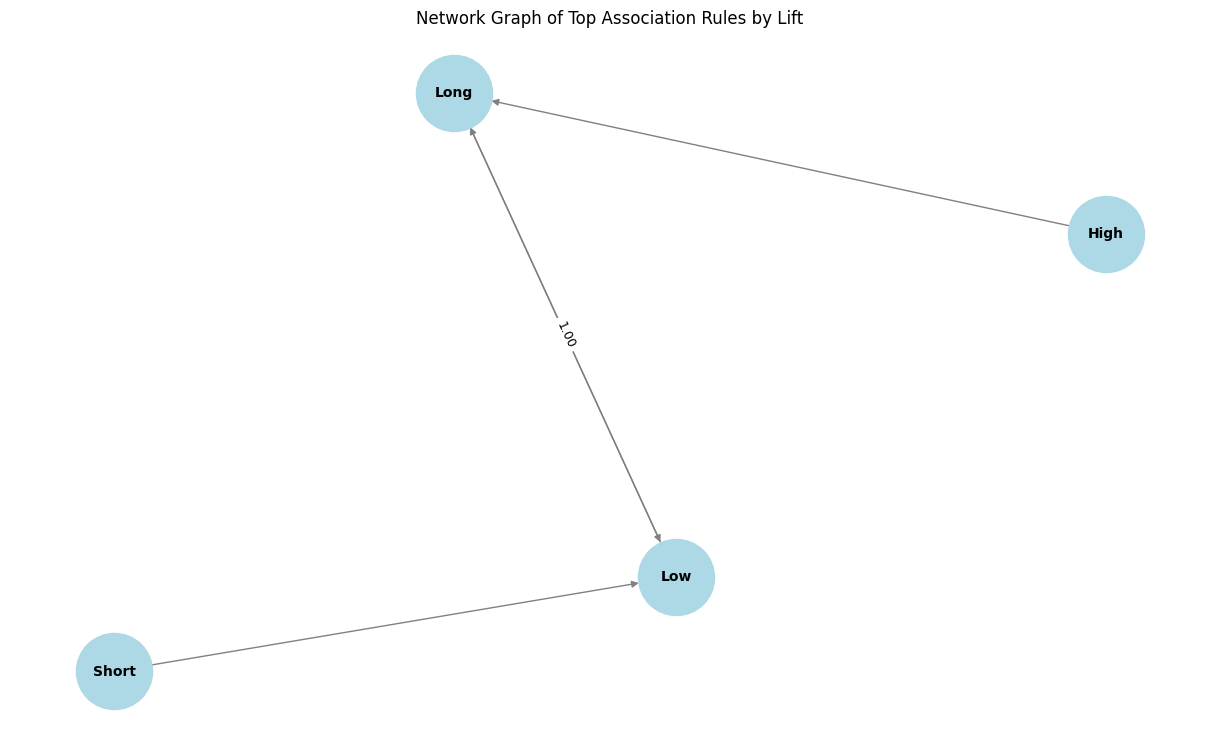

In [35]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

file_path = "transaction_data_for_ARM.csv"
df = pd.read_csv(file_path)

df['Transaction'] = df['Transaction'].apply(eval)
transactions = df['Transaction'].tolist()

def calculate_support(transactions, itemset):
    count = sum(1 for transaction in transactions if itemset.issubset(transaction))
    return count / len(transactions)

def generate_frequent_itemsets(transactions, min_support):
    item_counts = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            item_counts[frozenset([item])] += 1

    num_transactions = len(transactions)
    frequent_itemsets = {itemset: count / num_transactions for itemset, count in item_counts.items() if (count / num_transactions) >= min_support}

    current_itemsets = set(frequent_itemsets.keys())
    while current_itemsets:
        new_itemsets = set()
        for itemset1, itemset2 in combinations(current_itemsets, 2):
            merged_itemset = itemset1 | itemset2
            if len(merged_itemset) == len(itemset1) + 1 and merged_itemset not in frequent_itemsets:
                support = calculate_support(transactions, merged_itemset)
                if support >= min_support:
                    frequent_itemsets[merged_itemset] = support
                    new_itemsets.add(merged_itemset)
        current_itemsets = new_itemsets

    return frequent_itemsets

def generate_association_rules(frequent_itemsets, transactions, min_confidence):
    rules = []
    for itemset in frequent_itemsets.keys():
        if len(itemset) > 1:
            for antecedent_size in range(1, len(itemset)):
                for antecedent in combinations(itemset, antecedent_size):
                    antecedent = frozenset(antecedent)
                    consequent = itemset - antecedent
                    antecedent_support = calculate_support(transactions, antecedent)
                    rule_support = frequent_itemsets[itemset]
                    confidence = rule_support / antecedent_support if antecedent_support > 0 else 0
                    lift = confidence / calculate_support(transactions, consequent) if calculate_support(transactions, consequent) > 0 else 0

                    if confidence >= min_confidence:
                        rules.append((antecedent, consequent, rule_support, confidence, lift))

    return rules

min_support = 0.05
min_confidence = 0.5

frequent_itemsets = generate_frequent_itemsets(transactions, min_support)
rules = generate_association_rules(frequent_itemsets, transactions, min_confidence)

rules_df = pd.DataFrame(rules, columns=["Antecedents", "Consequents", "Support", "Confidence", "Lift"])

# Get top 15 rules by support, confidence, and lift
top_support = rules_df.sort_values(by="Support", ascending=False).head(15)
top_confidence = rules_df.sort_values(by="Confidence", ascending=False).head(15)
top_lift = rules_df.sort_values(by="Lift", ascending=False).head(15)

print("Top 15 Rules by Support:")
print(top_support)
print("\nTop 15 Rules by Confidence:")
print(top_confidence)
print("\nTop 15 Rules by Lift:")
print(top_lift)

G = nx.DiGraph()
for _, row in top_lift.iterrows():
    antecedents = ', '.join(map(str, row['Antecedents']))
    consequents = ', '.join(map(str, row['Consequents']))
    G.add_edge(antecedents, consequents, weight=row['Lift'])

plt.figure(figsize=(12, 7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', edge_color='gray', font_size=10, font_weight='bold')
edge_labels = {(antecedents, consequents): f"{row['Lift']:.2f}" for _, row in top_lift.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Network Graph of Top Association Rules by Lift")
plt.show()